## Data Preprocessing

In [1]:
# Imports
import numpy as np
import pandas as pd
# import dcMinMaxFunctions as dc
# import dcor
from scipy.misc import derivative
from sklearn.model_selection import train_test_split
import math

import torch
from scipy import stats
import wandb
from cov_help import *

In [2]:
model = nn.Sequential(
            nn.Linear(54, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 7),
            nn.Softmax(dim=1)

        )

In [3]:
#find number of parameters in model
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(count_parameters(model))

45383


In [4]:
df=pd.read_csv("data/covtype.csv")
# multiply second row by 2
df.iloc[1] = df.iloc[1]*2
df

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,5180,112,4,424,-12,780,440,470,302,12450,...,0,0,0,0,0,0,0,0,0,10
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581007,2396,153,20,85,17,108,240,237,118,837,...,0,0,0,0,0,0,0,0,0,3
581008,2391,152,19,67,12,95,240,237,119,845,...,0,0,0,0,0,0,0,0,0,3
581009,2386,159,17,60,7,90,236,241,130,854,...,0,0,0,0,0,0,0,0,0,3
581010,2384,170,15,60,5,90,230,245,143,864,...,0,0,0,0,0,0,0,0,0,3


In [5]:
X = df.drop("Cover_Type",axis=1).values
Y= df["Cover_Type"].values

In [6]:
def normalize(x):
    x_normed = 1*x / x.max(0, keepdim=True)[0]
    return x_normed



In [7]:
X = torch.Tensor(X)
Y = torch.Tensor(Y)
X = normalize(X)

In [8]:
# max_dist = torch.cdist(X, X).max()
# print(max_dist)
# for i in range(len(X)):
#     if(i%1000==0):
#         print(i)
#         print
#     for j in range(i,len(X)):
#         dist = torch.dist(X[i],X[j])
#         if(dist>max_dist):
#             max_dist = dist
            



In [9]:
#Write code to convert Y from 1,2,3,4,5,6,7 to 0,1,2,3,4,5,6
Y = Y-1
Y = Y.type(torch.LongTensor)


In [10]:
X = X[::10]
Y= Y[::10]

In [11]:
data_path = "data/covtype.csv"
norm=1
X,Y = cov_data_loader(data_path,norm=norm)
max_dist = torch.cdist(X, X).max()
print(max_dist) 

tensor(0.9416)


In [12]:
Y[0:10]

tensor([4, 4, 4, 4, 0, 4, 4, 1, 0, 1])

In [13]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [14]:
#write a code to choose evenly sampled subset of X and Y so that only 10% data remains
# X_train = X_train[::10]
# Y_train = Y_train[::10]



## Estimating Data Densities

#### Gaussian Kernel Density Estimation & Derivative

In [15]:
def gau_ker(u):
    return torch.pow(2*torch.tensor(torch.pi),u.shape[1]/(-2))*torch.exp(torch.bmm(u.view(u.shape[0], 1, u.shape[1]), u.view(u.shape[0],  u.shape[1],1))/(-2)).cuda()


def py_kde(x,X_t,h):
    norm = X_t.shape[0]*(h**x.shape[1])
    prob = torch.zeros(x.shape[0]).cuda()
    for i in range(len(X_t)):
        prob+= (torch.squeeze(gau_ker((x - X_t[i])/h))/norm).cuda()
    return(prob)


def py_kde_der(p_x,x):
    # x.requires_grad = True
    # p_x = py_kde(x,X_t,h)
    return (torch.autograd.grad(p_x,x,torch.ones_like(p_x),allow_unused=True,create_graph=True)[0]).cuda()


def gau_ker_der(X,h):
    N= X.shape[0]
    d = X.shape[1]
    grad = torch.zeros(X.shape)
    for n in range(N):
        for i in range(d):
            for j in range(N):
                grad[n][i]+= torch.exp(-1*torch.dot((X[n]-X[j]),(X[n]-X[j]))/(2*h*h))*(X[n][i] -X[j][i]) /(N*(h**(d+2))*((2*math.pi)**(d/2)))

    return grad

#### Confidence Intervals

In [16]:

def CI_KDE(p_x,n,h,d,alpha):
    return( stats.norm.ppf(1-alpha/2)*torch.sqrt(p_x/((2**d)*math.sqrt(torch.pi**d)*n*h**(d))).cuda() )

def CI_KDE_der(p_x_der,p_x,n,h,d,alpha):
    return( p_x_der*stats.norm.ppf(1-alpha/2)*torch.sqrt(1/(p_x.unsqueeze(dim=1)*(2**d)*math.sqrt(torch.pi**d)*n*h**(d))).cuda() )

#### Example on Data

In [17]:
n = len(X)
d = X.shape[1]
alpha=0.01
h=n**(-1./(d+4))
x = X[0:1000].detach().cuda()
x.requires_grad = True
f = py_kde(x,x,h)
f_der = py_kde_der(f,x)

In [18]:
h

0.8276729740613151

In [19]:
f_der/f.unsqueeze(dim=1)

tensor([[ 4.2023e-02,  3.3746e-02,  4.1772e-03,  ...,  1.4568e-05,
          1.1455e-05,  4.8000e-06],
        [ 3.7382e-02, -1.3021e-02,  3.8616e-03,  ...,  1.4643e-05,
          1.1495e-05,  4.8310e-06],
        [ 7.1138e-02,  2.7528e-02,  2.3118e-03,  ...,  1.4539e-05,
          1.1465e-05,  4.7379e-06],
        ...,
        [-1.8066e-01,  4.4793e-02, -1.0829e-03,  ...,  1.4479e-05,
         -3.0024e-04,  4.3854e-06],
        [-9.7191e-02,  1.3910e-02, -2.3581e-03,  ...,  1.4791e-05,
          1.1736e-05,  4.6439e-06],
        [-2.1025e-02,  3.1352e-02, -2.6411e-03,  ...,  1.4326e-05,
          1.1524e-05,  4.3846e-06]], device='cuda:0', grad_fn=<DivBackward0>)

In [20]:
ci = CI_KDE(f,n,h,d,alpha)
ci_der = CI_KDE_der(f_der,f,n,h,d,alpha)

## Training the model

In [92]:

import torch
import torch.nn as nn
import torch.nn.functional as F
class Net(nn.Module):
    def __init__(self,p):
        super(Net, self ).__init__()
        
        self.loss_reg = 0
        self.p =p 
        self.x = 0
        self.y = 0
        self.H_net1 = nn.Sequential(
            nn.Linear(54, 128),
            nn.Sigmoid(),
            nn.Linear(128, 256),
            nn.Sigmoid(),
            nn.Linear(256, 54*54).cuda()
        )
        self.X_net = nn.Sequential(
            nn.Linear(54, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 7),
            nn.Softmax(dim=2)

        )
        
    def forward(self, x):
        def H_mul(z):
            H12 = self.H_net1(z)
            H12= H12.reshape(z.shape[0],d,d)
            x12 = torch.matmul(z,H12)
            return(x12)
    
        
        def batch_jacobian(func, z, create_graph=False):
            # x in shape (Batch, Length)
            def _func_sum(z):
                return func(z).sum(dim=0)
            return torch.squeeze(torch.autograd.functional.jacobian(_func_sum, z, create_graph=create_graph)).permute(1,0,2)
        
        x.requires_grad =True
        p = self.p
        self.x = x
        d = x.shape[1]
        bs = x.shape[0]
        x= torch.unsqueeze(x,1)
        z = x.cuda()
        loss_reg = torch.zeros(bs,d).cuda()
        for i in range(p):
            H = self.H_net1(z).cuda()
            H = H.reshape(bs,d,d)
            
            J = batch_jacobian(H_mul, z, create_graph=True)
            z = torch.matmul(z,H).cuda()
          
            J_int =-torch.log(torch.abs(torch.det(J)))
            print(J_int)
            loss_reg = loss_reg + torch.squeeze(torch.autograd.grad(J_int, x,torch.ones_like(J_int),allow_unused=True,create_graph= True)[0]).cuda()
        self.loss_reg = loss_reg
        self.y = z
        y = self.X_net(z)
        return y

In [95]:
net = Net(4).to(torch.device("cuda"))
x = X[0:3]
net(x)
net.loss_reg

# loss = net.loss_reg.sum()
# loss.backward(retain_graph=True)
# x.grad

tensor([-14.0633, -14.0712, -14.0702], device='cuda:0', grad_fn=<NegBackward0>)
tensor([-13.8768, -13.8846, -13.9041], device='cuda:0', grad_fn=<NegBackward0>)
tensor([-14.0622, -14.0588, -14.0439], device='cuda:0', grad_fn=<NegBackward0>)
tensor([-14.2419, -14.2583, -14.2708], device='cuda:0', grad_fn=<NegBackward0>)


tensor([[-0.3234, -0.7693, -0.8887, -0.2414, -0.1618, -0.6293,  0.0275,  0.1875,
          0.4580,  0.4194, -0.4029,  0.3065,  0.9666, -0.2815, -0.5516, -1.1587,
          0.6399, -0.5782, -0.3469,  0.2795, -0.6986,  0.9810, -2.0371, -0.3194,
         -0.6768, -0.0958, -0.6037,  2.1016,  0.3830, -0.4112,  0.5383,  1.2991,
         -0.6947, -0.1659,  0.0726, -0.1052, -1.5091,  0.8768, -0.6838,  0.5625,
          0.5225,  0.7852,  1.3750, -0.3908,  0.4139,  0.7174, -0.3678, -0.3707,
         -0.0808, -0.5189,  0.4334, -0.2020, -0.9053, -0.6403],
        [-0.3110, -0.7791, -0.8755, -0.2442, -0.1414, -0.6387,  0.0310,  0.1878,
          0.4460,  0.4113, -0.4104,  0.3062,  0.9773, -0.2675, -0.5538, -1.1700,
          0.6277, -0.5732, -0.3426,  0.2462, -0.6812,  0.9584, -2.0119, -0.3063,
         -0.6908, -0.0949, -0.5891,  2.0933,  0.3686, -0.4315,  0.5448,  1.2842,
         -0.6983, -0.1528,  0.0594, -0.1210, -1.5011,  0.8799, -0.6839,  0.5717,
          0.5131,  0.7796,  1.3724, -0.3795, 

In [23]:

import torch
import torch.nn as nn
import torch.nn.functional as F
class Net2(nn.Module):
    def __init__(self,p):
        super(Net2, self ).__init__()
        
        self.loss_reg = 0
        self.p =p 
        self.x = 0
        self.y = 0
        self.H_net1 = nn.Sequential(
            nn.Linear(18, 128),
            nn.Sigmoid(),
            nn.Linear(128, 256),
            nn.Sigmoid(),
            nn.Linear(256, 18*18).cuda()
        )
        self.H_net2 = nn.Sequential(
            nn.Linear(18, 128),
            nn.Sigmoid(),
            nn.Linear(128, 256),
            nn.Sigmoid(),
            nn.Linear(256, 18*18).cuda()
        )
        self.H_net3 = nn.Sequential(
            nn.Linear(18, 128),
            nn.Sigmoid(),
            nn.Linear(128, 256),
            nn.Sigmoid(),
            nn.Linear(256, 18*18).cuda()
        )
        self.X_net = nn.Sequential(
            nn.Linear(54, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 7),
            nn.Softmax(dim=2)

        )
        
    def forward(self, x):
        def H_mul(z):
            H11 = self.H_net1(z[:,:,0:18])
            H12 = self.H_net2(z[:,:,18:36])
            H13 = self.H_net3(z[:,:,36:54])
            H11= H11.reshape(z.shape[0],18,18)
            H12= H12.reshape(z.shape[0],18,18)
            H13= H13.reshape(z.shape[0],18,18)
            x11 = torch.matmul(z[:,:,0:18],H11)
            x12 = torch.matmul(z[:,:,18:36],H12)
            x13 = torch.matmul(z[:,:,36:54],H13)
        
            x = torch.cat((x11,x12,x13),dim=2)
            
            return(x)
    
        
        def batch_jacobian(func, z, create_graph=False):
            # x in shape (Batch, Length)
            def _func_sum(z):
                return func(z).sum(dim=0)
            return torch.squeeze(torch.autograd.functional.jacobian(_func_sum, z, create_graph=create_graph)).permute(1,0,2)
        
        x.requires_grad =True
        p = self.p
        self.x = x
        d = x.shape[1]
        bs = x.shape[0]
        x= torch.unsqueeze(x,1)
        z = x.cuda()
        z1 = z[:,:,0:18]
        z2 = z[:,:,18:36]
        z3 = z[:,:,36:54]
        loss_reg = torch.zeros(bs,d).cuda()
        for i in range(p):
            
            H1 = self.H_net1(z1).cuda()
            H2 = self.H_net2(z2).cuda()
            H3 = self.H_net3(z3).cuda()
            H1 = H1.reshape(bs,18,18)
            H2 = H2.reshape(bs,18,18)
            H3 = H3.reshape(bs,18,18)
            

            
            
            # H = H.reshape(bs,d,d)
            
            # J1 = batch_jacobian(H_mul1, z1, create_graph=True)
            # J2 = batch_jacobian(H_mul2, z2, create_graph=True)
            # J3 = batch_jacobian(H_mul3, z3, create_graph=True)
            J = batch_jacobian(H_mul, z, create_graph=True)
           

            z1 = torch.matmul(z1,H1).cuda()
            z2 = torch.matmul(z2,H2).cuda()
            z3 = torch.matmul(z3,H3).cuda()
            z = torch.cat((z1,z2,z3),dim=2).cuda()
            J_int =-torch.log(torch.abs(torch.det(J)))
            loss_reg = loss_reg + torch.squeeze(torch.autograd.grad(J_int, x,torch.ones_like(J_int),allow_unused=True,create_graph= True)[0]).cuda()
           
        self.loss_reg = loss_reg
        self.y = z
        y = self.X_net(z)
        return y.squeeze(dim=1)

In [24]:
net = Net2(4).to(torch.device("cuda"))
x = X[0:3]
net(x)

loss = net.loss_reg.sum()
loss.backward(retain_graph=True)
x.grad


RuntimeError: cusolver error: CUSOLVER_STATUS_INTERNAL_ERROR, when calling `cusolverDnCreate(handle)`. If you keep seeing this error, you may use `torch.backends.cuda.preferred_linalg_library()` to try linear algebra operators with other supported backends. See https://pytorch.org/docs/stable/backends.html#torch.backends.cuda.preferred_linalg_library

In [120]:

import torch
import torch.nn as nn
import torch.nn.functional as F
class Net5(nn.Module):
    def __init__(self,p):
        super(Net5, self ).__init__()
        
        self.loss_reg = 0
        self.p =p 
        self.x = 0
        self.y = 0
        self.J_Int =0

        self.H_net1 = nn.Sequential(

            nn.Linear(54, 128),
            nn.LeakyReLU(10),
            # nn.Sigmoid(),
            nn.Linear(128, 64),
            # nn.LeakyReLU(10),
            #  nn.Linear(256, 128),
            nn.LeakyReLU(5),
            # nn.Sigmoid(),
            # nn.ReLU(),
            # nn.Linear(128, 64),
            # nn.LeakyReLU(5),

            nn.Linear(64, 54).cuda()
        )
        self.X_net = nn.Sequential(
            nn.Linear(54, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 7),
            nn.Softmax(dim=2)

        )
        
    def forward(self, x):
        def H_mul(z):
            y = self.H_net1(z)
            # y = torch.norm(z,dim =2).unsqueeze(1)*y
            
            return(y)

           
    
        
        def batch_jacobian(func, z, retain_graph = False,create_graph=False):
            # x in shape (Batch, Length)
            def _func_sum(z):
                return func(z).sum(dim=0)
            return torch.squeeze(torch.autograd.functional.jacobian(_func_sum, z, create_graph=create_graph)).permute(1,0,2)
        
        x.requires_grad =True
        p = self.p
        self.x = x
        d = x.shape[1]
        bs = x.shape[0]
        x= torch.unsqueeze(x,1)
        z = x.cuda()
        loss_reg = torch.zeros(bs,d).cuda()
        for i in range(p):
            y = self.H_net1(z).cuda()
           
            # y = torch.norm(x.cuda(),dim =2).unsqueeze(1)*y
          
            J = batch_jacobian(H_mul, z, create_graph=True)
            # print(torch.det(J)) 
           
            # J_int =torch.det(J)

            J_int =-torch.log(torch.abs(torch.det(J)))
          
            loss_reg = loss_reg + torch.squeeze(torch.autograd.grad(J_int, x,torch.ones_like(J_int),allow_unused=True,retain_graph= True)[0]).cuda()
            z = y
        
        self.loss_reg = loss_reg
        self.y = z
        y = self.X_net(z)
        return y

In [121]:
net = Net5(1).to(torch.device("cuda"))
net(X[0:4])

net.loss_reg

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0.]], device='cuda:0')

In [110]:
X[0:2].size()

torch.Size([2, 54])

In [111]:
from graphviz import Digraph
import torch
from torch.autograd import Variable


# make_dot was moved to https://github.com/szagoruyko/pytorchviz
from torchviz import make_dot

In [112]:
make_dot(net.loss_reg).view()

'Digraph.gv.pdf'

Error: no "view" rule for type "application/pdf" passed its test case
       (for more information, add "--debug=1" on the command line)


In [113]:

import torch
import torch.nn as nn
import torch.nn.functional as F
class Net3(nn.Module):
    def __init__(self,p):
        super(Net3, self ).__init__()
        
        self.loss_reg = 0
        self.p =p 
        self.x = 0
        self.y = 0
        self.k = 20
        self.H_net1 = nn.Sequential(
            nn.Linear(54, 128),
            nn.LeakyReLU(10),
            nn.Linear(128, 64),
            nn.ReLU(),

            nn.Linear(64, 54*2*self.k).cuda()
        )
        self.X_net = nn.Sequential(
            nn.Linear(54, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 7),
            nn.Softmax(dim=2)

        )
        
    def forward(self, x):
        def H_mul(z):
            h_c_m = self.H_net1(z)
            h_1_m = h_c_m[:,:,0:self.k*d]
            h_2_m = h_c_m[:,:,self.k*d:]
            h_1_m = h_1_m.reshape(z.shape[0],self.k,d)
            h_2_m = h_2_m.reshape(z.shape[0],self.k,d)
            h_2_t_m = torch.transpose(h_2_m, 1, 2)
            H_m = torch.matmul(h_2_t_m,h_1_m)
            z_m = torch.matmul(z,H_m)
            return(z_m)

           
    
        
        def batch_jacobian(func, z, create_graph=False):
            # x in shape (Batch, Length)
            def _func_sum(z):
                return func(z).sum(dim=0)
            return torch.squeeze(torch.autograd.functional.jacobian(_func_sum, z, create_graph=create_graph)).permute(1,0,2)
        
        x.requires_grad =True
        p = self.p
        self.x = x
        d = x.shape[1]
        bs = x.shape[0]
        x= torch.unsqueeze(x,1)
        z = x.cuda()
        loss_reg = torch.zeros(bs,d).cuda()
        for i in range(p):
            h_c = self.H_net1(z).cuda()
            h_1 = h_c[:,:,0:self.k*d]
            h_2 = h_c[:,:,self.k*d:]
           

            h_1 = h_1.reshape(bs,self.k,d)
            h_2 = h_2.reshape(bs,self.k,d)
            h_2_t = torch.transpose(h_2, 1, 2)
       
            H = torch.matmul(h_2_t,h_1).cuda()
          
          
            H = H.reshape(bs,d,d)
            
            J = batch_jacobian(H_mul, z, create_graph=True)

            z = torch.matmul(z,H).cuda()
            J_int =-torch.log(torch.abs(torch.det(J)))
            print(J_int)
           
            loss_reg = loss_reg + torch.squeeze(torch.autograd.grad(J_int, x,torch.ones_like(J_int),allow_unused=True,create_graph= True)[0]).cuda()
        self.loss_reg = loss_reg
        self.y = z
        y = self.X_net(z)
        return y

In [114]:
net = Net3(1).to(torch.device("cuda"))
net(X[0:3])

net.loss_reg

tensor([inf, inf, inf], device='cuda:0', grad_fn=<NegBackward0>)


tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan]], device='cuda:0',
       grad_fn=<AddBackward0>)

In [31]:
nn.LeakyReLU(1.1),

(LeakyReLU(negative_slope=1.1),)

In [32]:
class Net4(nn.Module):
    def __init__(self,p):
        super(Net4, self ).__init__()
        
        self.loss_reg = 0
        self.p =p 
        self.x = 0
        self.y = 0
        self.H_net2 = nn.Sequential(
            nn.Linear(54, 128).cuda(),
            nn.LeakyReLU(3),
            # nn.Sigmoid(),
        
            nn.Linear(128, 256),
            nn.LeakyReLU(3),
            # nn.Sigmoid(),
            nn.Linear(256, 54).cuda()
        )


        
        self.X_net = nn.Sequential(
            nn.Linear(54, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 7),
            nn.Softmax(dim=2)

        )
        
    def forward(self, x):
        def H_mul(z):
            x12 = self.H_net2(z)

            x12 = torch.norm(z,dim=2)*x12
            
            # x12 = x12*z
            return(x12)


        
        def batch_jacobian(func, z, create_graph=False):
            # x in shape (Batch, Length)
            def _func_sum(z):
                return func(z).sum(dim=0)
          
            return torch.squeeze(torch.autograd.functional.jacobian(_func_sum, z, create_graph=create_graph)).permute(1,0,2)
        
        x.requires_grad =True
        x = x.cuda()
        p = self.p
        self.x = x
        d = x.shape[1]
        bs = x.shape[0]
        x= torch.unsqueeze(x,1)
        z = x
        loss_reg = torch.zeros(bs,d).cuda()
        for i in range(p):
            y = self.H_net2(z).cuda()
            print(y.shape)
            print(torch.norm(z,dim=2).shape)
            
            J = batch_jacobian(H_mul, z, create_graph=True)
            # print(J)
            J_int =-torch.log(torch.abs(torch.det(J)))
            z = torch.norm(z,dim=2)*y
            print(torch.det(J))
            loss_reg = loss_reg + torch.squeeze(torch.autograd.grad(J_int, x,torch.ones_like(J_int),allow_unused=True,create_graph= True)[0]).cuda()
        self.loss_reg = loss_reg
        self.y = z
        y = self.X_net(z)
        return y

In [33]:
net = Net4(1).to(torch.device("cuda"))
net(X[0:2])

net.loss_reg

torch.Size([2, 1, 54])
torch.Size([2, 1])


RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 4 is not equal to len(dims) = 3

In [ ]:
a = torch.tensor([[1.0,0,0],[2,0,0]])
b = torch.norm(a,dim=1)*a
print(b)

RuntimeError: The size of tensor a (2) must match the size of tensor b (3) at non-singleton dimension 1

In [ ]:
torch.norm(torch.tensor([[[1.0,0,0],[2.0,0,0]]]),dim=2)

tensor([[1., 2.]])

In [ ]:
import torch.optim as optim

# criterion = nn.BCELoss(reduction= 'none')
def my_loss(y_pred,y_train,reg_loss):
    loss = criterion(y_pred,y_train) +reg_loss
    return loss
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
torch.autograd.set_detect_anomaly(False)
net_5 = Net(1)
import torch.optim.lr_scheduler as lr_scheduler
#loss function for multiclass classification
criterion = nn.CrossEntropyLoss()



In [ ]:
def train_model_priv(net,trainloader,optimizer,epochs,h,rate=10,device= torch.device('cpu'),print_cond = True,only_reg_flag=0):
    # scheduler = lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
    net = net.to(device)
    criterion = nn.CrossEntropyLoss()
    for epoch in range(epochs):  # loop over the dataset multiple times
        # scheduler.step()
        running_loss = 0.0
        
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            
            inputs = data[0].to(device)
            inputs.requires_grad = True
            labels = data[1].to(device)
            f = py_kde(inputs,inputs,h)
            f_der = py_kde_der(f,inputs)

            # zero the parameter gradients
            optimizer.zero_grad()
            # forward + backward + optimize
            outputs = net(inputs)
            if(only_reg_flag):
                loss = torch.norm(f_der/f.view(f.shape[0],1)+ net.loss_reg,dim=1).sum()
                
            else:
                loss = criterion(torch.squeeze(outputs),torch.squeeze(labels)) + torch.norm(f_der/f.view(f.shape[0],1)+ net.loss_reg,dim=1).sum()
            loss.backward(retain_graph=True)
            optimizer.step()
          

      
            # print statistics
            # print(loss.sum().shape)
            running_loss += loss.sum().detach().cpu()
            # if i % 100 == 99:    # print every 2000 mini-batches
            # if((i+1)%10==0):
            if(True):
                if(print_cond):
                    print('%d loss: %.10f' %
                            (epoch + 1, running_loss /(rate*10*trainloader.batch_size)))
                    running_loss = 0.0

 


In [ ]:
train_priv = torch.utils.data.TensorDataset(X,Y)

trainloader_priv = torch.utils.data.DataLoader(train_priv, batch_size=3000,
                                          shuffle=True, num_workers=2)

In [117]:
train_priv = torch.utils.data.TensorDataset(X,Y)

trainloader_priv = torch.utils.data.DataLoader(train_priv, batch_size=1000,
                                          shuffle=True, num_workers=2)
net_5 = Net5(1)
optim = torch.optim.Adam(net_5.parameters(),lr=0.001)
train_model_priv(net_5,trainloader_priv,optim,30,h=0.82,rate=1,device=torch.device('cuda'),only_reg_flag=1)


Error: You must call wandb.init() before wandb.log()

In [122]:
import torch.optim as optim

# # criterion = nn.BCELoss(reduction= 'none')
# def my_loss(y_pred,y_train,reg_loss):
#     loss = criterion(y_pred,y_train) +reg_loss
#     return loss
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
torch.autograd.set_detect_anomaly(False)
net_5 = Net5(1)
import torch.optim.lr_scheduler as lr_scheduler
#loss function for multiclass classification
criterion = nn.CrossEntropyLoss()


In [123]:
net_5= net_5.cuda()
data=X
batch_size = 1
epochs = 10
Y = Y.cuda()
opt1 = torch.optim.Adam(net_5.parameters(),lr=0.00001)
# scheduler = lr_scheduler.LinearLR(opt1, start_factor=1.0, end_factor=0.1, total_iters=10)
net_5.train()
bs = 400
for epoch in range(epochs):
    for ct in range(0,len(X),bs):
        x = data[ct:bs+ct].detach().cuda()

        opt1.zero_grad()
        x_hat = net_5(x).cuda()
        # f = py_kde(x,x,0.65)
        f_x = py_kde(x,x,0.65)
        f_x_der = py_kde_der(f_x,x)
    
        loss = torch.linalg.norm(f_x_der/f_x.view(f_x.shape[0],1)+ net_5.loss_reg,dim=1)
        loss.backward(torch.ones_like(loss), retain_graph=True)
        opt1.step()
        print("Epoch number:",epoch,"  Iteration number:",ct," LR :",opt1.param_groups[0]["lr"], " Loss:",torch.sum(loss)/bs, "Reg Loss:",torch.sum(torch.linalg.norm(f_x_der/f_x.view(f_x.shape[0],1)+net_5.loss_reg,dim=1)/bs))


Epoch number: 0   Iteration number: 0  LR : 1e-05  Loss: tensor(0.8930, device='cuda:0', grad_fn=<DivBackward0>) Reg Loss: tensor(0.8930, device='cuda:0', grad_fn=<SumBackward0>)
Epoch number: 0   Iteration number: 400  LR : 1e-05  Loss: tensor(0.4961, device='cuda:0', grad_fn=<DivBackward0>) Reg Loss: tensor(0.4961, device='cuda:0', grad_fn=<SumBackward0>)
Epoch number: 0   Iteration number: 800  LR : 1e-05  Loss: tensor(0.7659, device='cuda:0', grad_fn=<DivBackward0>) Reg Loss: tensor(0.7659, device='cuda:0', grad_fn=<SumBackward0>)
Epoch number: 0   Iteration number: 1200  LR : 1e-05  Loss: tensor(1.0060, device='cuda:0', grad_fn=<DivBackward0>) Reg Loss: tensor(1.0060, device='cuda:0', grad_fn=<SumBackward0>)
Epoch number: 0   Iteration number: 1600  LR : 1e-05  Loss: tensor(0.8932, device='cuda:0', grad_fn=<DivBackward0>) Reg Loss: tensor(0.8932, device='cuda:0', grad_fn=<SumBackward0>)
Epoch number: 0   Iteration number: 2000  LR : 1e-05  Loss: tensor(0.9420, device='cuda:0', gra

KeyboardInterrupt: 

In [ ]:
import torch.optim as optim

criterion = nn.BCELoss(reduction= 'none')
def my_loss(y_pred,y_train,reg_loss):
    loss = criterion(y_pred,y_train) +reg_loss
    return loss
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
torch.autograd.set_detect_anomaly(False)
net_10 = Net(10)
import torch.optim.lr_scheduler as lr_scheduler

In [ ]:
net_10= net_10.cuda()
data=X.cuda()
batch_size = 1
epochs = 10
Y = Y.cuda()
opt1 = torch.optim.Adam(net_10.parameters(),lr=0.001)
# scheduler = lr_scheduler.LinearLR(opt1, start_factor=1.0, end_factor=0.1, total_iters=10)
net_10.train()
bs = 500
for epoch in range(epochs):
    for ct in range(0,len(X),bs):
        x = data[ct:bs+ct].detach().cuda()

        opt1.zero_grad()
        x_hat = net_10(x)
        # f = py_kde(x,x,0.65)
        f_x = py_kde(x,x,0.65)
        f_x_der = py_kde_der(f_x,x)
        loss = criterion(torch.squeeze(x_hat[0:,0:,0]),torch.squeeze(Y[ct:bs+ct])) +torch.linalg.norm(f_x_der/f_x.view(f_x.shape[0],1)+ net_10.loss_reg,dim=1)
        loss.backward(torch.ones_like(loss), retain_graph=True)
        opt1.step()
        print("Epoch number:",epoch,"  Iteration number:",ct," LR :",opt1.param_groups[0]["lr"], " Loss:",torch.sum(loss)/bs, "Reg Loss:",torch.sum(torch.linalg.norm(f_x_der/f_x.view(f_x.shape[0],1)+net_10.loss_reg,dim=1)/bs))
    # if(epoch%20==19):

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 15.73 GiB total capacity; 3.13 GiB already allocated; 44.75 MiB free; 3.72 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

## Upper bound on Epsilon


In [ ]:
data=X



losses= torch.zeros(X.shape[0])
bs = 1000
n = bs
h = 0.65
d = X.shape[1]
alpha= 0.01
for ct in range(0,len(X),bs):
    x = data[ct:bs+ct].detach()
    x_hat = net_5(x)
    f = py_kde(x,x,0.65)
    f_der = py_kde_der(f,x)
    ci = CI_KDE(f,n,h,d,alpha)
    loss =torch.max(torch.linalg.norm(f_der/(f-ci).view(f.shape[0],1)+net_5.loss_reg,dim=1),torch.linalg.norm(f_der/(f+ci).view(f.shape[0],1)+net_5.loss_reg,dim=1)) 
    losses[ct:bs+ct] =loss

In [19]:
# net = Net(1)
net = torch.load("Models/net_1_cov")
# net.load_state_dict(state_dict)

In [20]:
train_priv = torch.utils.data.TensorDataset(X,Y)

trainloader_priv = torch.utils.data.DataLoader(train_priv, batch_size=1000,
                                        shuffle=True, num_workers=2,drop_last=True)

In [21]:
optim = torch.optim.Adam(net.parameters(),lr=0.00003)

In [13]:
net.to(torch.device('cuda'))
net.eval()
test_model(net,trainloader_priv)

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [107]:
net.eval()
test_loader = trainloader_priv
correct = 0
total = 0
losses =0
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        outputs = net(inputs)
        loss = criterion(torch.squeeze(outputs),torch.squeeze(labels))
        losses+=loss.sum()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [105]:
losses/len(X)

tensor(0.0021)

In [67]:
net

Net(
  (H_net1): Sequential(
    (0): Linear(in_features=54, out_features=128, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=256, out_features=2916, bias=True)
  )
  (X_net): Sequential(
    (0): Linear(in_features=54, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=7, bias=True)
    (5): Softmax(dim=2)
  )
)

In [64]:
net(X[0:3])

tensor([[[6.6744e-02, 9.2670e-01, 2.1241e-03, 1.3546e-03, 9.6444e-04,
          1.2291e-03, 8.8563e-04]],

        [[4.8453e-02, 9.4747e-01, 1.3700e-03, 8.5512e-04, 5.7667e-04,
          7.4947e-04, 5.2757e-04]],

        [[5.4603e-02, 9.3788e-01, 2.3995e-03, 1.5850e-03, 1.1224e-03,
          1.3911e-03, 1.0192e-03]]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)

In [54]:
run = wandb.init(project="covertype 2")

lr_schedule = LearnerRateScheduler('step', base_learning_rate=0.00003, decay_rate = 0.99, decay_steps=1)
train_model_priv(net,trainloader_priv,optim,4,h=0.82,rate=10,device=torch.device('cuda'),only_reg_flag=2,lr_schedular=lr_schedule)

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


loss,█▄▄▄▆▃▄▄▇▆▄▄█▃▆▇▂▁▄▅▃▂▃▃▁▅▄▃▂▃▄▆▂▂▂▂▅▂▁▃
loss_reg,▁▁▁▁▁▁▁▁▁▁▁▁▁▃▂▂▂▁▂▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,0.00157
loss_reg,37.95282


KeyboardInterrupt: 

In [109]:
net =  torch.load("Models/net_1_cov")

In [110]:
X_emb,losses = create_model_embs(net,trainloader_priv,device= torch.device('cuda'),l=len(X),h=0.82)

In [111]:
(losses).sum()/len(X)

tensor(2.3786)

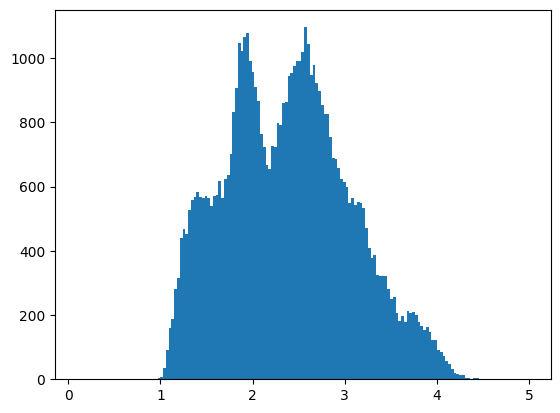

In [112]:

from matplotlib import pyplot as plt
import numpy as np
 
 
# Creating dataset
a = losses.detach()
 
# Creating histogram
fig, ax = plt.subplots()
ax.hist(a, bins = np.arange(0.1,5,0.03))
 
# Show plot
plt.show()

In [113]:
X_emb_train, X_emb_test, Y_train, Y_test = train_test_split(X_emb, Y, test_size=0.2)

In [114]:
train_emb_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_emb_train,Y_train), batch_size=1000,
                                        shuffle=True, num_workers=2)
test_emb_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_emb_test,Y_test), batch_size=1000,
                                        shuffle=True, num_workers=2)

In [119]:
net.cpu()
criterion = nn.CrossEntropyLoss()
model = nn.Sequential(
            nn.Linear(54, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 7),
            nn.Softmax(dim=1)

        )
optimizer = torch.optim.Adam(model.parameters(),lr=0.01,weight_decay=1e-4)
train_emb(model, train_emb_loader, criterion, optimizer, num_epochs=100,device=torch.device('cpu'))

Epoch [10], loss: 1.677
Epoch [20], loss: 1.676
Epoch [30], loss: 1.676
Epoch [40], loss: 1.676
Epoch [50], loss: 1.676
Epoch [60], loss: 1.676
Epoch [70], loss: 1.676
Epoch [80], loss: 1.676
Epoch [90], loss: 1.677
Epoch [100], loss: 1.676


In [ ]:
o = autoencoder1(X_train.detach())
X_emb_train = torch.squeeze(autoencoder1.y).detach()
o = autoencoder1(X_test.detach())
X_emb_test = torch.squeeze(autoencoder1.y).detach()


In [41]:
test_model(model,test_emb_loader)

Accuracy of the network on the test images: 49 %


In [ ]:

# o = autoencoder1(X)
# X_embs = torch.squeeze(autoencoder1.y.detach())
model = nn.Sequential(
    nn.Linear(12, 48),
    nn.ReLU(),
    nn.Linear(48, 32),
    nn.ReLU(),
    nn.Linear(32, 1),
    nn.Sigmoid(

    )
)
loss_fn = nn.BCELoss()  # binary cross entropy
optimizer = optim.Adam(model.parameters(), lr=0.001)
n_epochs = 2000
batch_size = 1000

for epoch in range(n_epochs):
    for i in range(0, len(X_emb_train), batch_size):
        Xbatch = X_emb_train[i:i+batch_size]
        y_pred = model(Xbatch)
        ybatch = Y_train[i:i+batch_size]
        loss = loss_fn(y_pred, ybatch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    #     print(loss)
    # print(f'Finished epoch {epoch}, latest loss {loss}')
# compute accuracy (no_grad is optional)
with torch.no_grad():
    y_pred = model(X_emb_test)
 
accuracy = (y_pred.round() == Y_test).float().mean()
print(f"Accuracy {accuracy}")

Accuracy 0.8339999914169312


In [ ]:
model1 = nn.Sequential(
    nn.Linear(12, 48),
    nn.ReLU(),
    nn.Linear(48, 32),
    nn.ReLU(),
    nn.Linear(32, 1),
    nn.Sigmoid(

    )
)
loss_fn = nn.BCELoss()  # binary cross entropy
optimizer1 = optim.Adam(model1.parameters(), lr=0.001)
n_epochs = 1000
batch_size = 1000
 
for epoch in range(n_epochs):
    for i in range(0, len(X_train), batch_size):
        Xbatch = X_train[i:i+batch_size]
        y_pred = model1(Xbatch)
        ybatch = Y_train[i:i+batch_size]
        loss = loss_fn(y_pred, ybatch)
        optimizer1.zero_grad()
        loss.backward()
        optimizer1.step()

with torch.no_grad():
    y_pred = model1(X_test)
 
accuracy = (y_pred.round() == Y_test).float().mean()
print(f"Accuracy {accuracy}")

Accuracy 0.871999979019165


In [35]:
model_path = "Models/cov_new_norm_1_2"
state_dict = torch.load(model_path)
from cov_help import *
    # Create an instance of Net
net = Net(1)
net.load_state_dict(state_dict)

<All keys matched successfully>

In [57]:
# prune_param = []
# for param in net.parameters():
#     print(param)
    # name = param.name
    # if( "H_net1" in name):
    #     prune_param.append((param,"weight"))
    #     print(param)
# prune_param = []
for name, param in net.named_parameters():
    print(name)
    # name = param.name
    # if( "H_net1" in name):
    #     prune_param.append((param,"weight"))
    #     print(param)
    



H_net1.0.weight
H_net1.0.bias
H_net1.2.weight
H_net1.2.bias
H_net1.4.weight
H_net1.4.bias
X_net.0.weight
X_net.0.bias
X_net.2.weight
X_net.2.bias
X_net.4.weight
X_net.4.bias
X_net.6.weight
X_net.6.bias


In [68]:
net.to(torch.device("cuda"))
net.H_net1[0].weight

Parameter containing:
tensor([[-0.0326,  0.0385,  0.0601,  ..., -0.1135, -0.1319, -0.0933],
        [ 0.0218, -0.0314, -0.0063,  ...,  0.0763, -0.1219, -0.1075],
        [ 0.1208, -0.0838,  0.1304,  ..., -0.0679,  0.1198, -0.1198],
        ...,
        [ 0.0521, -0.0298, -0.0997,  ...,  0.0153,  0.0183, -0.1232],
        [ 0.1172,  0.0730, -0.0087,  ...,  0.1323, -0.1369,  0.0438],
        [-0.1024, -0.1241,  0.0534,  ...,  0.0743,  0.0742,  0.0840]],
       device='cuda:0', requires_grad=True)

In [74]:
model_path = "Models/cov_new_norm_1_2"
state_dict = torch.load(model_path)
from cov_help import *
    # Create an instance of Net
net = Net(1).to(torch.device("cuda"))
net.load_state_dict(state_dict)
params_to_prune = [(net.H_net1[0],"weight"),(net.H_net1[2],"weight"),(net.H_net1[4],"weight")]

In [82]:
import torch
from torch import nn
import torch.nn.utils.prune as prune
import torch.nn.functional as F

prune.global_unstructured(
    params_to_prune,
    pruning_method=prune.L1Unstructured,
    amount=0.6,
)

In [83]:
X,Y = cov_data_loader(data_path,norm=norm)
max_dist = torch.cdist(X, X).max()

train_priv = torch.utils.data.TensorDataset(X,Y)

trainloader_priv = torch.utils.data.DataLoader(train_priv, batch_size=1000,
                                        shuffle=False, num_workers=2)

In [84]:
X_emb,losses = create_model_embs2(net,trainloader_priv,device= torch.device('cuda'),l=len(X),h=0.82)
losses,indices = torch.sort(losses*max_dist)

In [85]:
losses

tensor([0.4166, 0.4169, 0.4170,  ..., 1.8810, 1.9243, 1.9842])